This notebook replicates Example 3.1 in https://arxiv.org/abs/1903.04556.

In [1]:
import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as onp
import seaborn as sns; sns.set()

import jax.numpy as np
from jax import device_get, lax, random, vmap
from jax.config import config; config.update('jax_platform_name', 'cpu')
from jax.flatten_util import ravel_pytree
from jax.tree_util import tree_map, tree_multimap

import numpyro.distributions as dist
from numpyro.distributions.util import softmax
from numpyro.hmc_util import initialize_model, log_density, welford_covariance
from numpyro.mcmc import mcmc
from numpyro.handlers import sample, scale, seed, substitute

### banana model

In [2]:
def model(data, K=10):
    with scale(1. / K):
        x1 = sample('x1', dist.Normal(0, 0.5))
        x2 = sample('x2', dist.Normal(0, 0.5))
    return sample('obs', dist.Normal(x1 + x2 ** 2, np.sqrt(2)), obs=data)

### simulate data

In [3]:
def simulate(rng, num_data=10000):
    rngs = random.split(rng, num_data)
    return vmap(lambda rng: substitute(seed(model, rng), {'x1': 0.5, 'x2': 0})(None))(rngs)

data = simulate(random.PRNGKey(0))
shards = [data[i * 1000: i * 1000 + 1000] for i in range(10)]

### posterior

In [4]:
rngs = random.split(random.PRNGKey(1), 4)
init_params, potential_fn, constrain_fn = initialize_model(rngs, model, data, K=1)
samples = mcmc(num_warmup=4000, num_samples=4000, init_params=init_params, num_chains=4,
               potential_fn=potential_fn, constrain_fn=constrain_fn)



                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1       0.30       0.21       0.02       0.52     587.23       1.02
                  x2       0.01       0.44      -0.67       0.70    1069.51       1.00


In [5]:
# ground truth
x1 = np.linspace(-1.0, 1.0, 100)
x2 = np.linspace(-1.0, 1.0, 100)
X1, X2 = np.meshgrid(x1, x2)
potential_energy = lambda params: log_density(model, (data,), {'K': 1}, params)[0]
logP = vmap(vmap(potential_energy))({'x1': X1, 'x2': X2})
P = softmax(logP.reshape(-1)).reshape(logP.shape).clip(a_min=0.)

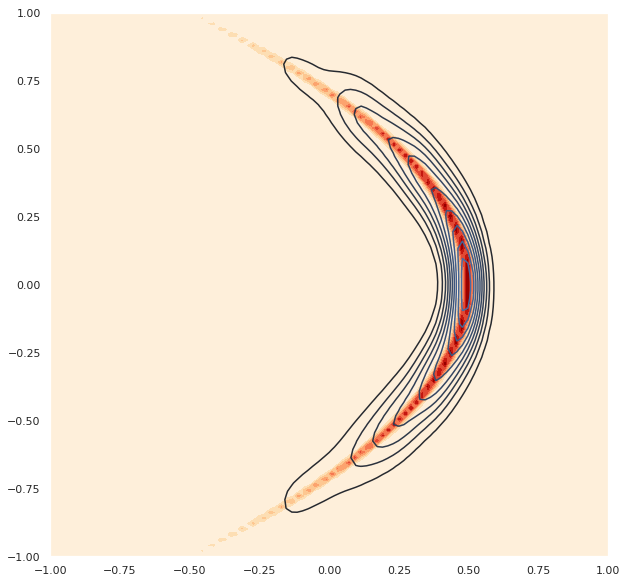

In [6]:
plt.figure(figsize=(10, 10))
plt.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(samples['x1'], samples['x2'])
plt.xlim([-1.0, 1.0])
plt.ylim([-1.0, 1.0])
plt.show()

### subposteriors

In [7]:
def get_subposterior(rng, shard):
    rngs = random.split(rng, 4)
    init_params, potential_fn, constrain_fn = initialize_model(rngs, model, shard)
    samples = mcmc(num_warmup=4000, num_samples=4000, init_params=init_params, num_chains=4,
                   potential_fn=potential_fn, constrain_fn=constrain_fn, print_summary=True)
    return samples

In [8]:
rngs = random.split(random.PRNGKey(1), 10)
# in the future, we can use pmap inside pmap
subposteriors = []
for i, (rng, shard) in enumerate(zip(rngs, shards)):
    sep = '=' * 40
    print('\n' + sep + ' SUBPOSTERIOR {} '.format(i) + sep, end='')
    subposteriors.append(get_subposterior(rng, shard))


======================================== SUBPOSTERIOR 0 ========================================

                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1      -0.32       0.76      -1.43       0.59      24.78       1.12
                  x2      -0.04       0.92      -1.45       1.34      10.29       1.22

======================================== SUBPOSTERIOR 1 ========================================

                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1      -0.04       0.55      -0.82       0.57     553.98       1.02
                  x2       0.02       0.73      -1.10       1.17    1096.93       1.00

======================================== SUBPOSTERIOR 2 ========================================

                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1      -0.13       0.72      -1.09       0.59     311.92       1.02
       

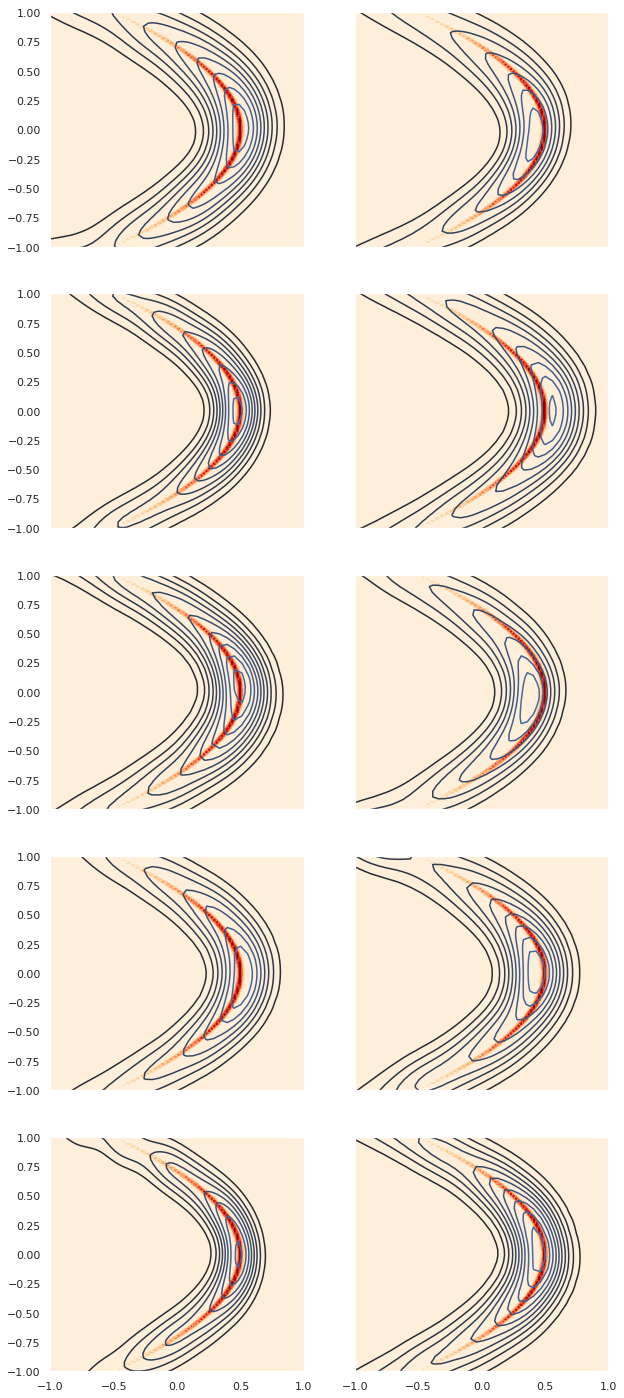

In [9]:
_, axes = plt.subplots(5, 2, figsize=(10, 25), sharex=True, sharey=True)
for i in range(5):
    for j in range(2):
        subposterior = subposteriors[i + 5 * j]
        axes[i, j].contourf(X1, X2, P, cmap='OrRd')
        sns.kdeplot(subposterior['x1'], subposterior['x2'], ax=axes[i, j])
        axes[i, j].set_xlim([-1.0, 1.0])
        axes[i, j].set_ylim([-1.0, 1.0])

### consensus

Ref: https://ai.google/research/pubs/pub41849 algorithm in Figure 2.

In [10]:
def covariance(samples):
    wc_init, wc_update, wc_final = welford_covariance(diagonal=False)
    state = wc_init(samples.shape[1])
    state = lax.fori_loop(0, samples.shape[0], lambda i, state: wc_update(samples[i], state), state)
    return wc_final(state)[0]

In [11]:
def consensus(subposteriors):
    posterior = tree_multimap(lambda *args: np.stack(args), *subposteriors)
    posterior_flat = vmap(vmap(lambda sample: ravel_pytree(sample)[0]))(posterior)
    
    weights = vmap(lambda x: np.linalg.inv(covariance(x)))(posterior_flat)
    normalized_weights = np.matmul(np.linalg.inv(np.sum(weights, axis=0)), weights)
    
    samples_flat = np.einsum('ijk,ilk->lj', normalized_weights, posterior_flat)
    _, unravel_fn = ravel_pytree(tree_map(lambda x: x[0][0], posterior))
    return vmap(lambda x: unravel_fn(x))(samples_flat)

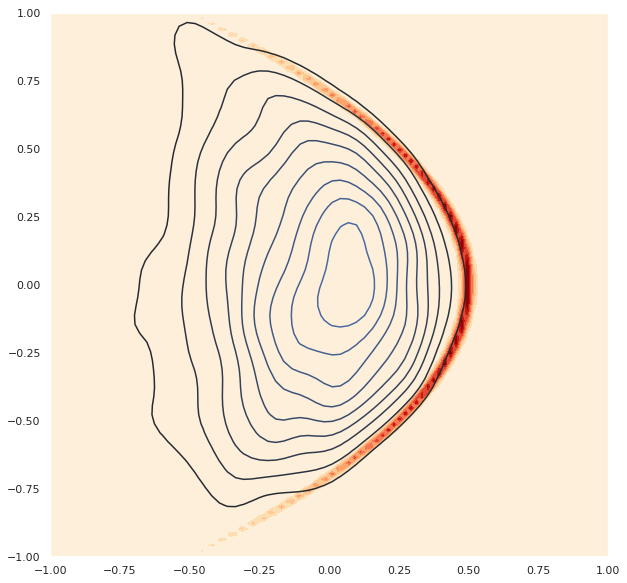

In [12]:
consensus_samples = consensus(subposteriors)
plt.figure(figsize=(10, 10))
plt.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(consensus_samples['x1'], consensus_samples['x2'])
plt.xlim([-1.0, 1.0])
plt.ylim([-1.0, 1.0])
plt.show()

### parametric

Ref: https://arxiv.org/abs/1311.4780

In [13]:
def parametric(subposteriors):
    posterior = tree_multimap(lambda *args: np.stack(args), *subposteriors)
    posterior_flat = vmap(vmap(lambda sample: ravel_pytree(sample)[0]))(posterior)

    sub_precisions = vmap(lambda x: np.linalg.inv(covariance(x)))(posterior_flat)
    cov = np.linalg.inv(np.sum(sub_precisions, axis=0))
    sub_means = np.mean(posterior_flat, axis=1)
    weights = np.matmul(cov, sub_precisions)
    mean = np.einsum('ijk,ik->j', weights, sub_means)

    samples_flat = dist.MultivariateNormal(mean, cov).sample(random.PRNGKey(2),
                                                             posterior_flat.shape[1:2])
    _, unravel_fn = ravel_pytree(tree_map(lambda x: x[0][0], posterior))
    return vmap(lambda x: unravel_fn(x))(samples_flat)

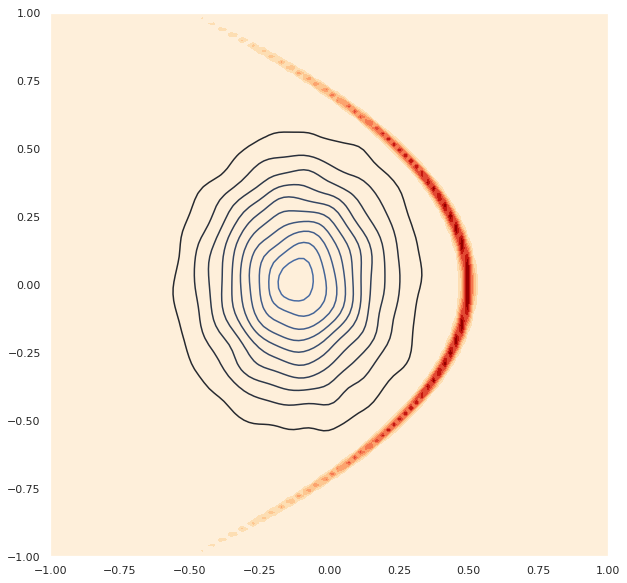

In [14]:
parametric_samples = parametric(subposteriors)
plt.figure(figsize=(10, 10))
plt.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(parametric_samples['x1'], parametric_samples['x2'])
plt.xlim([-1.0, 1.0])
plt.ylim([-1.0, 1.0])
plt.show()